In [1]:
import pandas as pd
import numpy as np
import cmath
import math
from scipy.optimize import fmin, minimize
from astropy import units as u
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [2]:
class data:
    u: float
    v: float
    phase: float
    amp: float
    sigma: float
    vis_data: complex
    def __init__(self, u, v, phase, amp, sigma):
        self.u = u
        self.v = v
        self.phase = phase
        self.amp = amp
        self.sigma = sigma
        self.vis_data = amp * np.exp(1j * math.radians(phase))

    def __repr__(self):
        return f"[u: {self.u}, v: {self.v}]"

    def __str__(self):
        return f"[u: {self.u}, v: {self.v}]"

image is a 2d numpy array
image is 2d of numbers (greyscale image)

In [3]:
# Assumption image is 80x80 pixels
# Pass in array of u,v coords then return array of interpolated values
def interpolate(image, coords, FOV):
    ft_image = np.fft.fftshift(np.fft.fft2(image)) # Investigate to make sure what this fft does

    kx_1 = 2*math.pi/FOV

    kx = np.linspace(ft_image.shape[0]//-2, (ft_image.shape[0])//2 - 1, ft_image.shape[0]) * kx_1
    ky = np.linspace(ft_image.shape[0]//-2, (ft_image.shape[1])//2 - 1, ft_image.shape[1]) * kx_1
    
    interp_real = RegularGridInterpolator((kx, ky), ft_image.real, bounds_error=False, method="linear")
    interp_imag = RegularGridInterpolator((kx, ky), ft_image.imag, bounds_error=False, method="linear")

    real = interp_real(coords)
    imag = interp_imag(coords)
    print(imag)
    return real + imag * 1j

Testing Interpolate
pip3 install --user scipy

In [4]:
n = 256

a = np.linspace(-50, 50, n)
x, y = np.meshgrid(a, a)

k = np.fft.fftfreq(n, a[1]-a[0])
kx, ky = np.meshgrid(k, k)

def Gaussian(sigma, x0=0, y0=0):
    dx = x - x0
    dy = y - y0
    return np.exp(-0.5 * (dx*dx + dy*dy) / (sigma * sigma))

def ring(nn=0.01):
    return np.maximum(Gaussian(10, *randpos(1)) - Gaussian(8, *randpos(1)), 0) + nn * noise(2)

def noise(alpha):
    white_noise = np.random.rand(n, n)-0.5 + 1j*(np.random.rand(n, n)-0.5)
    power_law = np.power(kx*kx + ky*ky + 1e-300, -0.5 * alpha)
    power_law[0,0] = 0
    img  = np.real(np.fft.ifft2(white_noise * power_law))
    img += np.min(img)
    img /= np.max(img)
    return img

def randpos(scale=1):
    x = (np.random.rand() - 0.5) * 2 * scale
    y = (np.random.rand() - 0.5) * 2 * scale
    return x, y

(-0.5, 255.5, 255.5, -0.5)

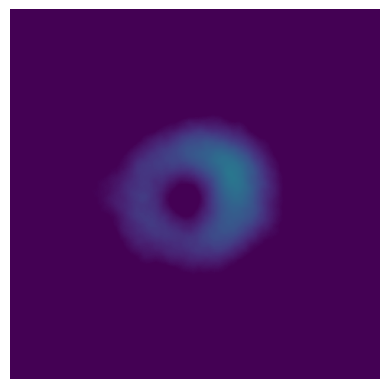

In [5]:
#sample = ring() # Sample is 256 by 256
sample = np.loadtxt("sample_image.csv", delimiter=",")
plt.figure()
#cm = copy(plt.get_cmap('afmhot'))
#cm.set_over('b')
plt.imshow(sample, vmin=0, vmax=0.5)
plt.axis('off')

In [6]:
np.savetxt("sample_image.csv", sample, delimiter=",")
#np.loadtxt("sample_image.csv", delimiter=",")

In [7]:
samp = np.array(sample)
samp_blank = samp * 0
samp_coords = [[1.81243945e-03+0.j, -1.65010891e-02-0.01426895j]]
temp_1 = interpolate(samp, samp_coords, 100 * u.uas)
print(temp_1)
temp_2 = interpolate(samp_blank, samp_coords, 100 * u.uas)
print(temp_2)

[-137.92053255]
[-2427.67503444-137.92053255j]
[0.]
[0.+0.j]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/interpolate/_rgi.py:374: ComplexWarning: Casting complex values to real discards the imaginary part
  xi = np.asarray(xi, dtype=float)


In [8]:
# p is the exponent of the regularizing terms
# The smaller p the more sensitive it is to noise
# TSV = Total Squared Variation
def calc_regularizer(image: np.array, tsv=False, p=None):
    if tsv and p == None:
        raise Exception("p value not set")
    reg = 0
    if tsv:
        image_lshift = np.copy(image, subok=True)
        image_lshift = np.roll(image_lshift, -1,axis=1)
        image_lshift[:,-1] = 0
        image_upshift = np.copy(image, subok=True)
        image_upshift = np.roll(image_upshift, -1, axis=0)
        image_upshift[-1] = 0

        term_1 = np.power(np.absolute(np.subtract(image_lshift, image)),p)
        term_2 = np.power(np.absolute(np.subtract(image_upshift, image)),p)
        reg = np.sum(np.add(term_1,term_2))
    return reg

In [9]:
def gradient_regularizer(image: np.array):
    image_lshift = np.copy(image, subok=True)
    image_lshift = np.roll(image_lshift, -1,axis=1)
    image_lshift[:,-1] = 0
    image_upshift = np.copy(image, subok=True)
    image_upshift = np.roll(image_upshift, -1, axis=0)
    image_upshift[-1] = 0
    image_rshift = np.copy(image, subok=True)
    image_rshift = np.roll(image_rshift, 1,axis=1)
    image_rshift[:,0] = 0
    image_dshift = np.copy(image, subok=True)
    image_dshift = np.roll(image_dshift, 1, axis=0)
    image_dshift[0] = 0
    g_reg = 4 * image - image_lshift - image_upshift - image_rshift - image_dshift
    return g_reg


While
Running

Computation of dirtied image

In [ ]:
testing


Translate u and v to a position to grid
    => Translate from gigalambda to grid
    ImageMeta(width=100 * u.uas)
    uvd  = width_in_as * 2 * pi
    divide by kx_1
    relates to integer indexes
python fftshift to array
    By default fft array is 0 is on the corner, negatives gets wrapped
    fftshift will centralize the 0 to the middle
python's RegularGridInterpolator will interpolate
    Research whether they support complex values now
    If not:
        Interpolate Real part and imagineary part separately

In [10]:
# Assumption image is 80px by 80px => 6400 variables
def loss(image, data_list: list[data], coords, p = 2, reg_weight = 1, FOV = 100*u.uas.to(u.rad)): #Ask about u.rad
    error_sum = 0
    vis_images = interpolate(image, coords, FOV)
    
    # Need to use the same selection as gradient
    # Make a second loss func
    """
    Try with no selection first
    """

    for i in range(len(data_list)):
        vis_data = data_list[i].amp * np.exp(1j * math.radians(data_list[i].phase)) #TODO Aks about the units here as well as U and V for gigalambda
        vis_image = vis_images[i]
        error = (abs(vis_image-vis_data) / data_list[i].sigma) ** 2
        error_sum += error
    
    return error_sum + reg_weight * calc_regularizer(image=image, tsv=True, p=2)

In [11]:
sample_coords = []
sample_data_list = []
print(loss(samp, sample_data_list, sample_coords))
print(loss(samp_blank, sample_data_list, sample_coords))

[]
4.139403793123961
[]
0.0


In [12]:
def gradient(data_list: list[data], coords, image, mode = 1): # 0 For central, -1 for backward, 1 for forward
    image_copy = np.copy(image, subok=True)
    upper_diff: float
    lower_diff: float
    h: float
    gradient_arr = np.empty(np.shape(image),dtype=np.complex_)
    if (mode == 0): # Central difference
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] += 1e-6 / 2
                upper_diff = loss(image_copy, data_list, coords)
                image_copy[row,col] -= 1e-6
                lower_diff = loss(image_copy, data_list, coords)
                image_copy[row,col] = image[row,col] # Reset that pixel to original value
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-6
    elif (mode == -1): # Backward difference
        upper_diff = loss(image, data_list, coords)
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] -= 1e-8 # Check with Misha 
                lower_diff = loss(image_copy, data_list, coords)
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-8
                image_copy[row,col] = image[row,col]
    elif (mode == 1) : # Forward difference is default
        lower_diff = loss(image, data_list, coords)
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] += 1e-8 # Check with Misha 
                upper_diff = loss(image_copy, data_list, coords)
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-8
                image_copy[row,col] = image[row,col]
    else:
        raise ValueError('Incorrect mode for finite differences')
    return gradient_arr
    #Return a Gradient 2d array?

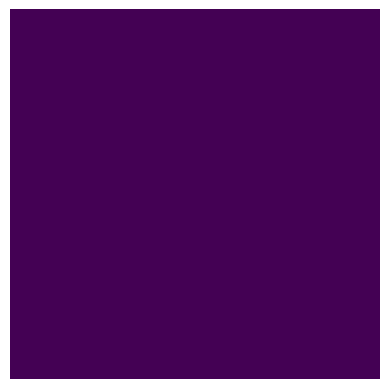

In [13]:
emp = np.zeros((80,80))
plt.figure()
plt.imshow(emp, vmin=0, vmax=0.5)
plt.axis('off')
plt.savefig('images/0.png')

In [27]:
def gradient_2(data_list: list[data], coords, coeffs, image, FOV = 100*u.uas.to(u.rad)):
    gradient_arr = np.empty(np.shape(image)) # Because we are in real space
    vis_images = interpolate(image, coords, FOV)
    for row in range(len(image)):
        for col in range(len(image[row])):
            gradient_sum = 0
            for i in range(len(data_list)):
                vis_data = data_list[i].vis_data
                vis_image = vis_images[i]
                term_1 = coeffs[row,col,i,0] * (np.conj(vis_image) - np.conj(vis_data))
                term_2 = coeffs[row,col,i,1] * (vis_image - vis_data)
                gradient_sum += (term_1 + term_2)/(data_list[i].sigma ** 2)
            gradient_arr[row,col] = gradient_sum
    return gradient_arr

In [24]:
def preprocess_gradient(data_list: list[data], coords, image):
    r, c = np.shape(image)
    preprocessed = np.empty([r,c,len(data_list),2], dtype=np.complex_)
    for row in range(len(image)):
        for col in range(len(image[row])):
            for datum in range(len(data_list)):
                term = ((2*np.pi*1j)/image.size)*(row*data_list[datum].u + col*data_list[datum].v) #.size for numpy array returns # of rows * # of cols
                term_1 = np.exp(term)
                term_2 = np.exp(-1*term)
                preprocessed[row,col,datum,0] = term_1
                preprocessed[row,col,datum,1] = term_2
    return preprocessed

coordinate descent method: Optimize with respect to a var, then freeze and optimize with another 
                           var... continue until reach a optimum
                           or subset of vars
Gauss-seidel Method: Use idea from here, don't actually try coding this
Stochastic gradient descent: The later stages you use, the more of the data in your subset
                             Start with a subset (representative, spread out over the data)
                             Random subset? 
Is there a quick way to compute dirty version of image
Gradient of Regularizers

Github
HPC Benchmark
Stochastic gradient descent: The later stages you use, the more of the data in your subset
    Start with a subset (representative, spread out over the data)
    Random subset? 
    subset like 10%
Gradient of Regularizer

Replot image every few steps

In [25]:
coeffs = preprocess_gradient(data_list, coords, emp)

In [26]:
coeffs

array([[[[ 1.        +0.00000000e+00j,  1.        +0.00000000e+00j],
         [ 1.        +0.00000000e+00j,  1.        +0.00000000e+00j],
         [ 1.        +0.00000000e+00j,  1.        +0.00000000e+00j],
         ...,
         [ 1.        +0.00000000e+00j,  1.        +0.00000000e+00j],
         [ 1.        +0.00000000e+00j,  1.        +0.00000000e+00j],
         [ 1.        +0.00000000e+00j,  1.        +0.00000000e+00j]],

        [[ 0.72896863-6.84547106e-01j,  0.72896863+6.84547106e-01j],
         [-0.42577929-9.04827052e-01j, -0.42577929+9.04827052e-01j],
         [ 0.79075635-6.12131026e-01j,  0.79075635+6.12131026e-01j],
         ...,
         [ 0.46619364+8.84682704e-01j,  0.46619364-8.84682704e-01j],
         [-0.68724289+7.26427708e-01j, -0.68724289-7.26427708e-01j],
         [ 0.32205916+9.46719545e-01j,  0.32205916-9.46719545e-01j]],

        [[ 0.06279052-9.98026728e-01j,  0.06279052+9.98026728e-01j],
         [-0.63742399+7.70513243e-01j, -0.63742399-7.70513243e-01j],
  

In [29]:
emp = np.zeros((80,80))
x = gradient_2(data_list, coords, coeffs, emp)
#x = gradient(data_list, coords, emp)

[0. 0. 0. ... 0. 0. 0.]


/var/folders/_b/trlmhkgj5xq968yccj4vtg1c0000gn/T/ipykernel_29777/2184829813.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient_arr[row,col] = gradient_sum


In [30]:
np.real(x)

array([[-4665858.68075455, -3433480.06936175, -1408698.37681857, ...,
         2257228.59940488,  3085676.02121527,  1985795.69174366],
       [ -107705.83399767, -1102873.58680317,  2225026.44149848, ...,
        -1628120.48536111,  -381532.08772881, -4432575.41989236],
       [ 1414222.23223292,   274940.04387248,  -495003.48555058, ...,
        -2353057.67002456,  1477027.89667769, -2061546.94487123],
       ...,
       [ -363864.98819004,  -783861.91930738, -2033919.68674573, ...,
          569752.59216931,   332658.60554209,   421196.1872791 ],
       [  608644.25781672, -1186281.65984302,  1339127.26422329, ...,
         1622891.46236696,  -714819.65486848,  1171234.64268029],
       [-1204822.31282108, -2507409.23731289,  -569172.05390961, ...,
        -2673646.01906133,  -541090.67083789,  3061837.78427972]])

In [31]:
np.savetxt("gradient_2.txt", np.real(x), delimiter=",")

In [46]:
def gradient_descent(image, data_list, coords, coeffs, subset_percent = 10):
    image_copy = np.copy(image, subok=True)
    # coeffs = preprocess_gradient(data_list, coords, image_copy)
    # loss needs same subset as gradient_2
    i = 0
    grad = None
    t = 10000000
    while grad is None or np.any(np.abs(grad) > 0.0000001): # Didn't finish before so never negative?
        plt.figure()
        plt.imshow(image_copy, vmin=0, vmax=0.5)
        plt.axis('off')
        plt.savefig('images/'+str(i)+'.png')

        #selection = np.random.choice(np.arange(len(data_list)), size=len(coords)*subset_percent//100, replace=False) # selection is full of indicies
        #subset = [data_list[index] for index in selection]
        prev_loss = loss(image_copy, data_list, coords)

        grad = gradient_2(data_list, coords, coeffs, image_copy) + gradient_regularizer(image_copy)
        new_image = image_copy - t * grad
        new_loss = loss(new_image, data_list, coords)
        
        while new_loss > prev_loss: # Only run when new_loss > prev_loss
            new_image = image_copy - t * grad
            new_loss = loss(new_image, data_list, coords)
            t /= 2

        loss_file = open("losses_2.txt","a")
        loss_file.write("--------------------------")
        loss_file.write("t-val" + str(t) + "\n")
        loss_file.write("prev_loss:" + str(prev_loss) + "\n")
        loss_file.write("new_loss:" + str(new_loss) + "\n")
        loss_file.close()

        image_copy -= t * 2 * grad
        i += 1
        """if i == 100:
            return"""

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


/var/folders/_b/trlmhkgj5xq968yccj4vtg1c0000gn/T/ipykernel_29777/2184829813.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient_arr[row,col] = gradient_sum


[-4.81199634e+12  2.10778992e+14  4.58577863e+08 ...  1.59010013e+14
  1.46193738e+09 -1.59012845e+14]
[-4.81199634e+12  2.10778992e+14  4.58577863e+08 ...  1.59010013e+14
  1.46193738e+09 -1.59012845e+14]
[-2.40599817e+12  1.05389496e+14  2.29288932e+08 ...  7.95050067e+13
  7.30968688e+08 -7.95064224e+13]
[-1.20299908e+12  5.26947479e+13  1.14644466e+08 ...  3.97525034e+13
  3.65484344e+08 -3.97532112e+13]
[-6.01499542e+11  2.63473740e+13  5.73222329e+07 ...  1.98762517e+13
  1.82742172e+08 -1.98766056e+13]
[-3.00749771e+11  1.31736870e+13  2.86611165e+07 ...  9.93812584e+12
  9.13710860e+07 -9.93830281e+12]
[-1.50374886e+11  6.58684349e+12  1.43305582e+07 ...  4.96906292e+12
  4.56855430e+07 -4.96915140e+12]
[-7.51874428e+10  3.29342175e+12  7.16527911e+06 ...  2.48453146e+12
  2.28427715e+07 -2.48457570e+12]
[-3.75937214e+10  1.64671087e+12  3.58263956e+06 ...  1.24226573e+12
  1.14213857e+07 -1.24228785e+12]
[-1.87968607e+10  8.23355437e+11  1.79131978e+06 ...  6.21132865e+11
  5.

/var/folders/_b/trlmhkgj5xq968yccj4vtg1c0000gn/T/ipykernel_29777/3601151780.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


[-3.44605242e-17  1.50946801e-15  3.28404938e-21 ...  1.13873080e-15
  1.04694860e-20 -1.13875107e-15]
[-3.45198367e-17  1.51206607e-15  3.28970179e-21 ...  1.14069075e-15
  1.04875058e-20 -1.14071106e-15]
[-3.45198367e-17  1.51206607e-15  3.28970179e-21 ...  1.14069075e-15
  1.04875058e-20 -1.14071106e-15]
[-3.45791491e-17  1.51466412e-15  3.29535420e-21 ...  1.14265070e-15
  1.05055256e-20 -1.14267104e-15]
[-3.46384615e-17  1.51726217e-15  3.30100660e-21 ...  1.14461065e-15
  1.05235453e-20 -1.14463103e-15]
[-3.46384615e-17  1.51726217e-15  3.30100660e-21 ...  1.14461065e-15
  1.05235453e-20 -1.14463103e-15]
[-3.46977740e-17  1.51986022e-15  3.30665901e-21 ...  1.14657060e-15
  1.05415651e-20 -1.14659101e-15]
[-3.47570864e-17  1.52245827e-15  3.31231142e-21 ...  1.14853055e-15
  1.05595849e-20 -1.14855100e-15]
[-3.47570864e-17  1.52245827e-15  3.31231142e-21 ...  1.14853055e-15
  1.05595849e-20 -1.14855100e-15]
[-3.48163988e-17  1.52505632e-15  3.31796383e-21 ...  1.15049050e-15
  1.

KeyboardInterrupt: 

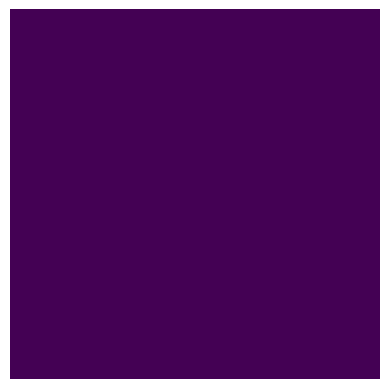

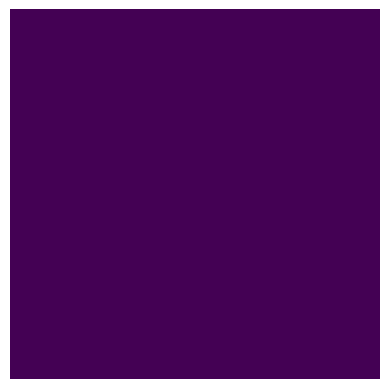

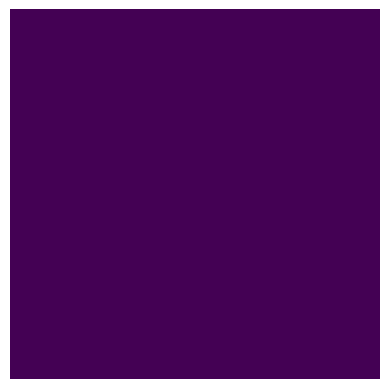

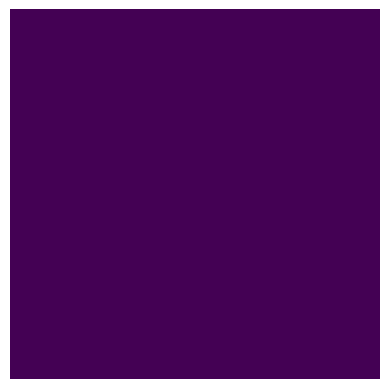

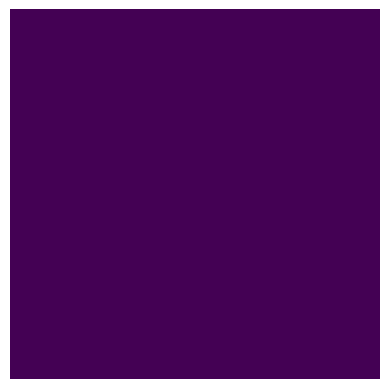

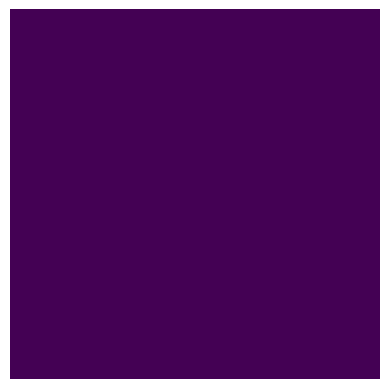

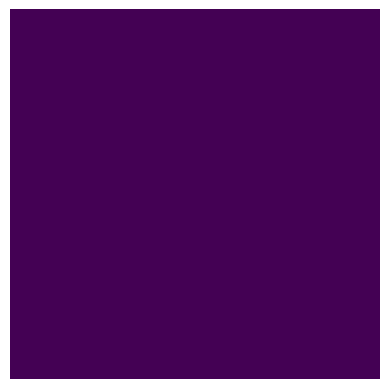

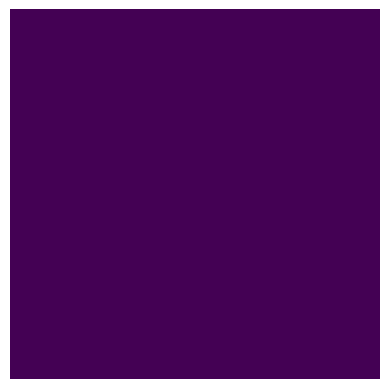

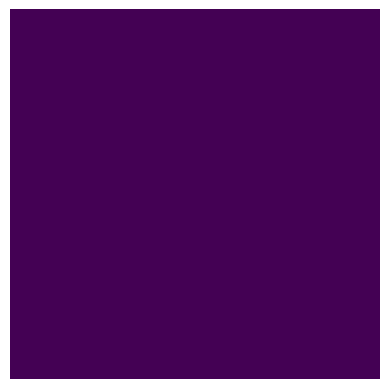

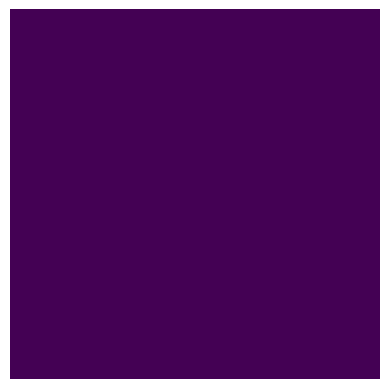

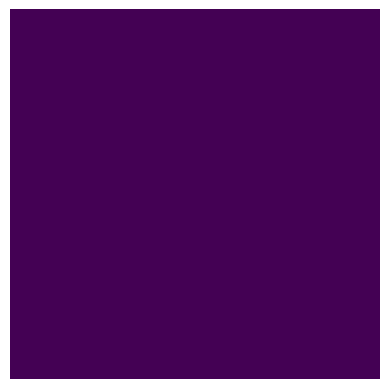

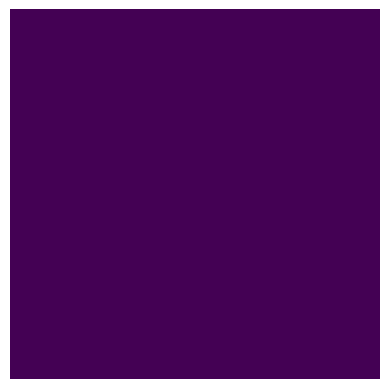

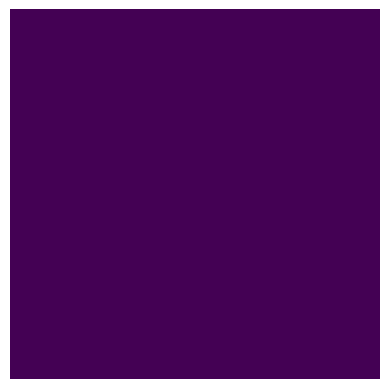

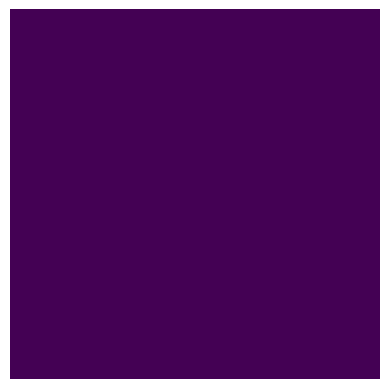

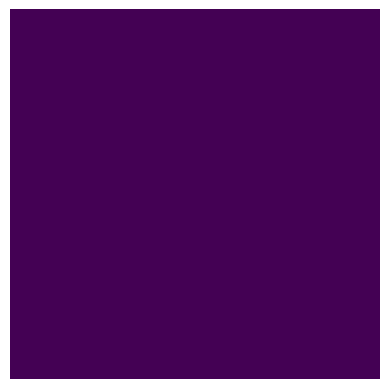

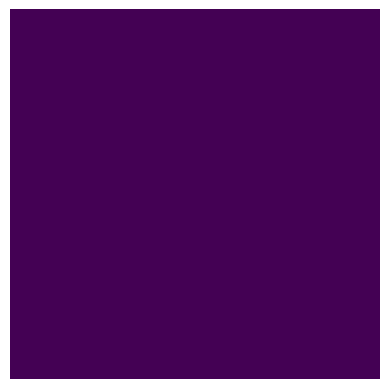

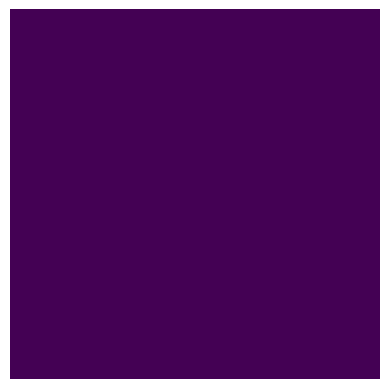

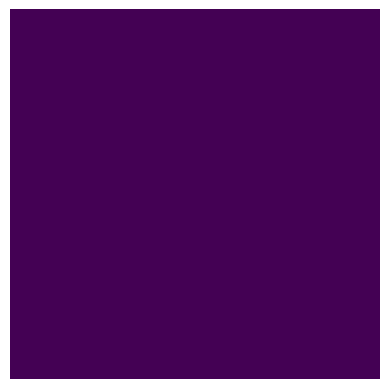

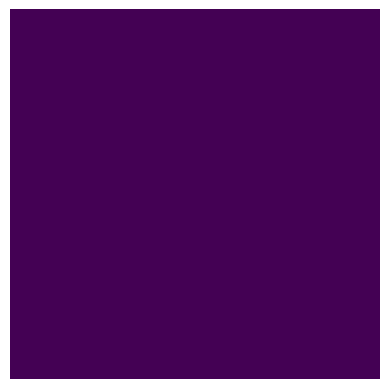

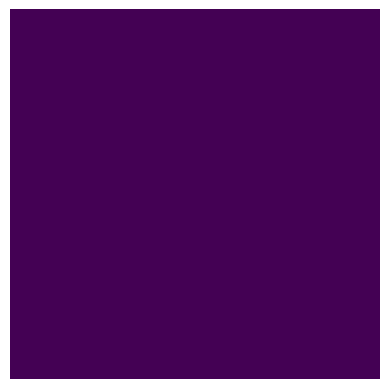

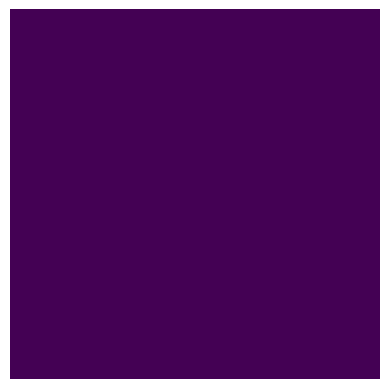

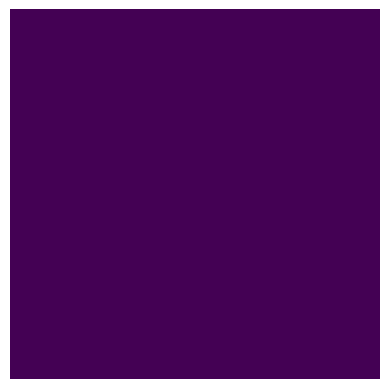

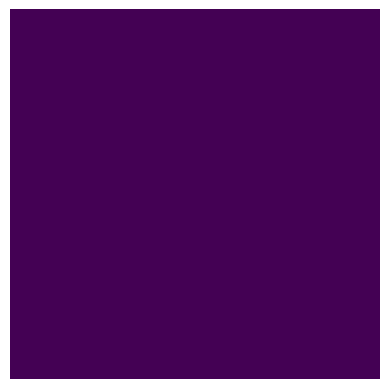

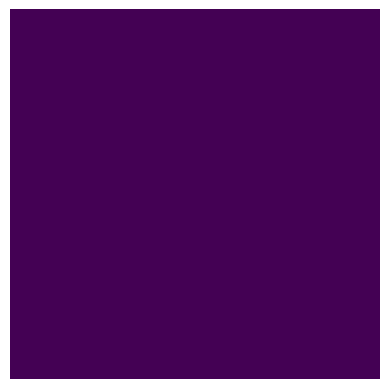

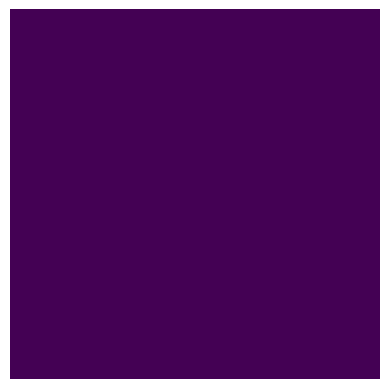

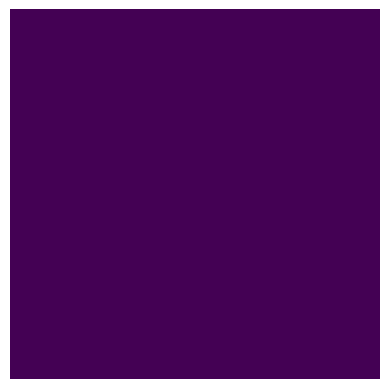

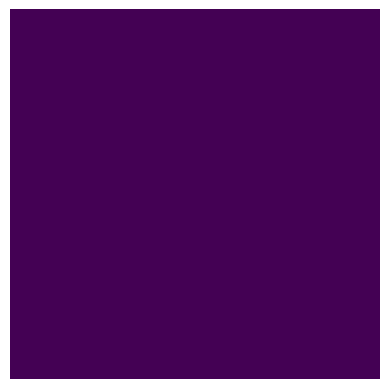

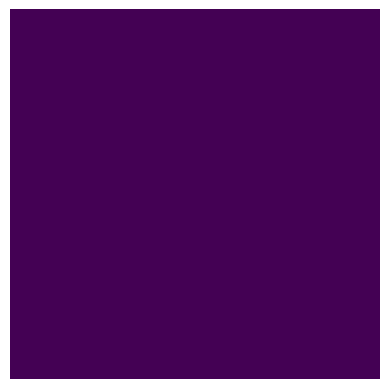

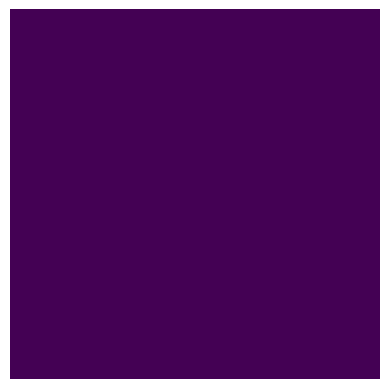

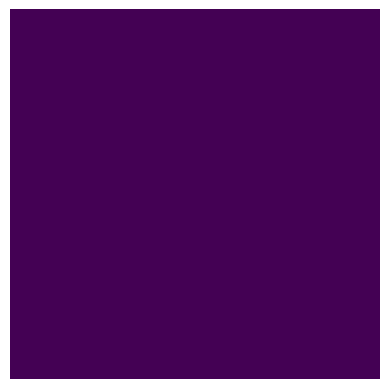

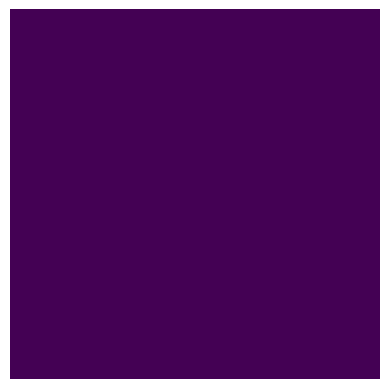

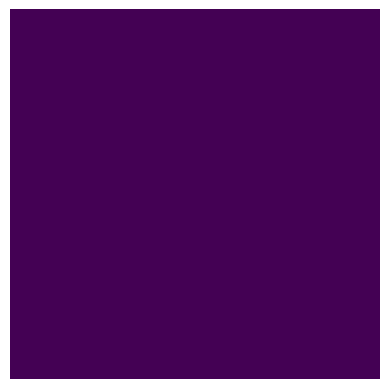

In [47]:
gradient_descent(emp, data_list, coords, coeffs)

In [ ]:
test = np.zeros((80,80))
ft_image = np.fft.fftshift(np.fft.fft2(test))
len(ft_image)

In [17]:
def process_data(data_df):
    coords = []
    data_list = []
    for i in range(len(data_df)):
        data_list.append(data(data_df.loc[i, 'U(lambda)'], data_df.loc[i, 'V(lambda)'], data_df.loc[i, 'Iphase(d)'], data_df.loc[i, 'Iamp(Jy)'], data_df.loc[i, 'Isigma(Jy)']))
        coords.append([data_df.loc[i, 'U(lambda)'], data_df.loc[i, 'V(lambda)']])
    coords = np.array(coords)
    return coords, data_list

In [18]:
def read_data(filename: str()):
    df = pd.read_csv(filename)
    return df

In [19]:
df = read_data("./data/SR1_M87_2017_095_hi_hops_netcal_StokesI.csv")
df


,#time(UTC),T1,T2,U(lambda),V(lambda),Iamp(Jy),Iphase(d),Isigma(Jy)
0,0.768056,AA,LM,1.081710e+09,-3.833722e+09,0.014292,-118.9454,0.005847
1,0.768056,AA,PV,-4.399933e+09,-4.509480e+09,0.136734,5.8638,0.004968
2,0.768056,AA,AP,8.349088e+05,-1.722271e+06,1.119780,58.1095,0.005243
3,0.768056,AP,LM,1.080840e+09,-3.832004e+09,0.018448,-137.6802,0.044576
4,0.768056,AP,PV,-4.400757e+09,-4.507747e+09,0.139619,-57.1724,0.032591
...,...,...,...,...,...,...,...,...
6453,8.165278,AZ,LM,-1.078324e+09,1.029597e+09,0.315983,10.9377,0.030449
6454,8.165278,AZ,JC,3.392180e+09,9.968579e+08,0.058864,46.0474,0.090288
6455,8.165278,JC,LM,-4.470504e+09,3.273711e+07,0.108582,-178.7050,0.043965
6456,8.165278,JC,SM,1.745735e+04,-1.192282e+05,1.123722,-29.5589,0.091870


In [20]:
coords, data_list = process_data(df)
len(data_list)

6458

Don't combine u and v into. They are 2D coordinates in fourier transform
vis = amp * np.exp(1j * phase)
turn phase into radians
interpolation to get sample value
80 pixel x 80 pixel

Find FOV
    => Hyperparameter
    => 100 microasc

# Add regularizers Here
    # need it for good restorations L2 Norm penalty
    # First (25) reg with variable p instead of 2
    # Write optimization loop (Gradient Descent?)
    # Reorg above
    # Hardcode Gradient Descent of data term in terms of function
    # Gradient by finding images pixel by pixel => Combine after to get final image NOOO
    # Does pytorch autodiff work with fft?

    # How long does it take to compute one gradient
    # Can use Central difference to approx gradient
    # h is.. check video, like 10^-6
    # forward difference will be faster but less accurate
    # Try both?

    # regularizers smooths out the image, doesn't like "rough" images
    # Make pixel next to each other similar to each other

In [ ]:
y = train_df['complex'].values
y = y.reshape(-1, 1)
train_df['constant'] = 1
columns = ['U(lambda)', 'V(lambda)', 'Isigma(Jy)']
x = train_df[columns].values

#initialize vector of weights
w = np.zeros([x.shape[0], 2])
print(w.shape)

In [ ]:
A = np.array([[4, 3, 2],
              [1, 2, 3],
              [0, -1, 5]])
B = np.empty(np.shape(A))

How slow is finite differences
Try to implement and understand the derivatives one works

In [ ]:
def f(x, y, z):
    return 2 * x**3 + y**4 - z

x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
z = np.linspace(7, 9, 33)

xg, yg ,zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)

data = f(xg, yg, zg)
interp = RegularGridInterpolator((x, y, z), data, bounds_error=False, method="cubic")
pts = np.array([[2.1, 6.2, 8.3],
                [3.3, 5.2, 7.1],
                [2.5, 5.5, 8.5],
                [1.00000001, 4.0000000000000001, 7.00008]])
for pt in pts:
    print(interp(pt))
    print(f(pt[0],pt[1],pt[2]))
    print("---------------------")

Runge Phenomenon and Gibbs

In [ ]:
x = np.array([[0,1,2],[4,5,6]])
y = np.array([[0,1,2],[4,5,6]])